In [15]:
import sys 
sys.path.append('..')

from models import DIFDensityEstimator,SoftmaxWeight,LocationScaleFlow
from models import EMDensityEstimator, NewEMDensityEstimator
from targets import Target, Uniform
%load_ext autoreload
%autoreload 2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


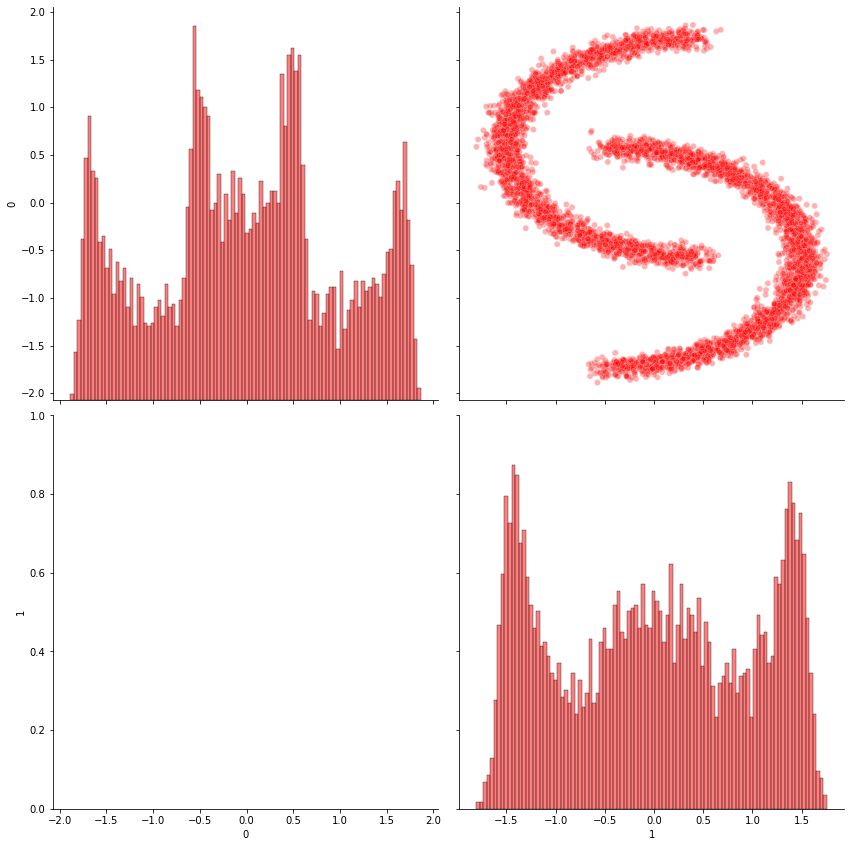

In [32]:
example = "Moons"
num_samples = 50000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

100%|██████| 50/50 [00:32<00:00,  1.54it/s, loss = 1.1361857652664185]


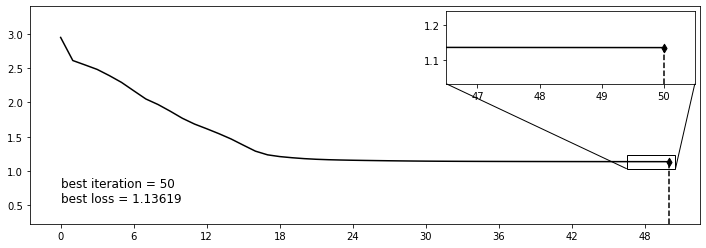

In [33]:
num_samples = target_samples.shape[0]
epochs = 50
K = 100
EM = NewEMDensityEstimator(target_samples,K)
loss_values = EM.train(epochs,visual=True)

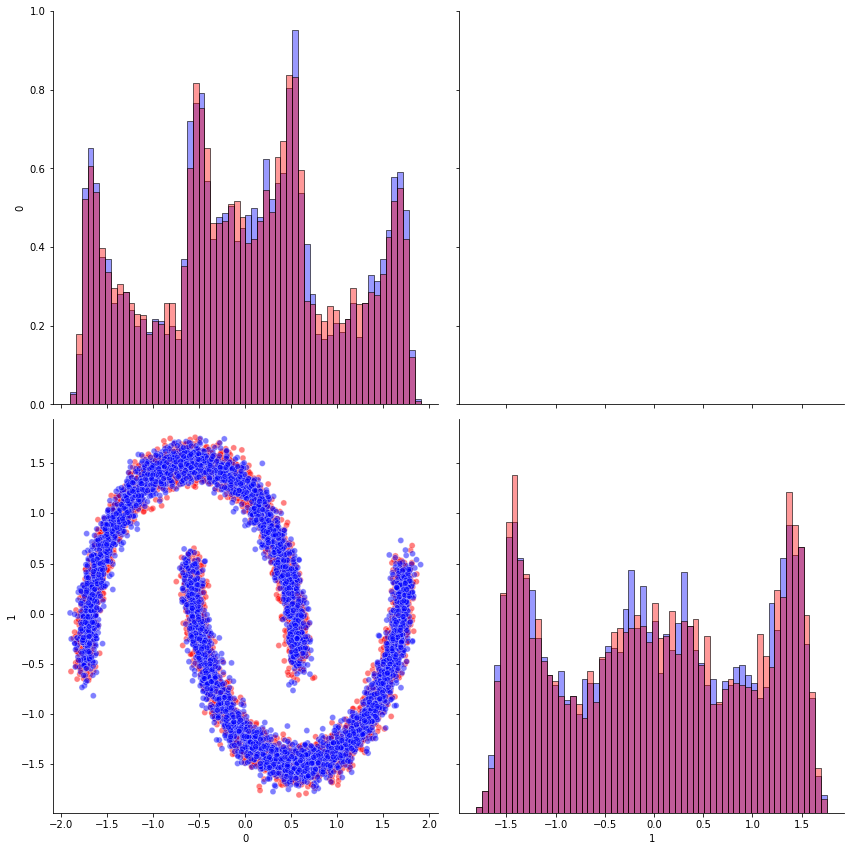

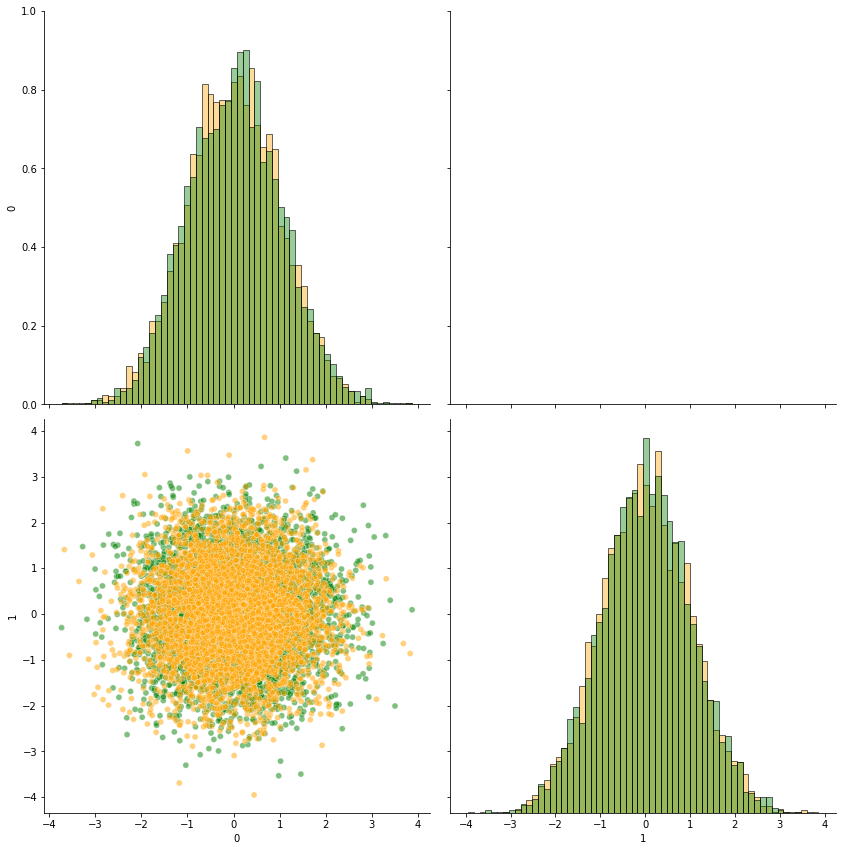

In [34]:
EM.model_visual()

In [5]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 1000
batch_size = 500
initial_T = EM.T
initial_T = LocationScaleFlow(K,p, mode = 'full_rank')
initial_w = SoftmaxWeight(K, p, [64,64,64], mode = 'NN')
initial_w.log_b = nn.Parameter(EM.log_pi)
initial_w.a = nn.Parameter(torch.zeros(K,p))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w) 
print(torch.mean(dif.log_density(target_samples)))
loss_values = dif.train(1000, visual = True)
dif.model_visual()

AttributeError: 'NewEMDensityEstimator' object has no attribute 'T'

In [ ]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 1000
batch_size = num_samples
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, p, [10,10,10], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 10))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_w.a = nn.Parameter(torch.zeros(K,p))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

In [ ]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 10000
batch_size = num_samples
K = 7
initial_T = LocationScaleFlow(K,p, mode = 'full_rank')
initial_w = SoftmaxWeightOver(K, p, [256,256,256], mode = 'Linear')
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()